# TensorFlow Tutorial #06
# CIFAR-10

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

이 튜토리얼은 CIFAR-10 데이터셋에 이미지를 분류하기 위한 콘볼루션 신경망을 만드는 방법을 보인다. 또한 학습과 평가 동안 다른 신경망을 사용하는 방법도 보인다.

이건 이전 튜토리얼로부터 만들어지므로, 텐서플로와 애드온 패키지 Pretty Tensor의 기본 이해가 필요하다.

## Flowchart

아래의 차트는 아래에서 구현될 콘볼루션 신경망의 자료 흐름을 대략적으로 보여준다. 첫째 신경망은 왜곡과 함께 전처리되어 입력 이미지를 인위적으로 늘리는 전처리 레이어가 있다. 이 신경망은 두개의 콘볼루션 레이어, 두개의 완전 연결 레이어 마지막으로 소프트맥스 분류 레이어가 있다. 콘볼루션 레이어의 가중치와 출력은 그 아래 큰 도표에서 더 자세히 보인다. 

여기서는 이미지가 잘못 분류된다. 이 이미지는 실제로 개이지만 신경망은 개인지 고양이인지 헷갈리고 이미지는 대부분 고양이로 생각한다

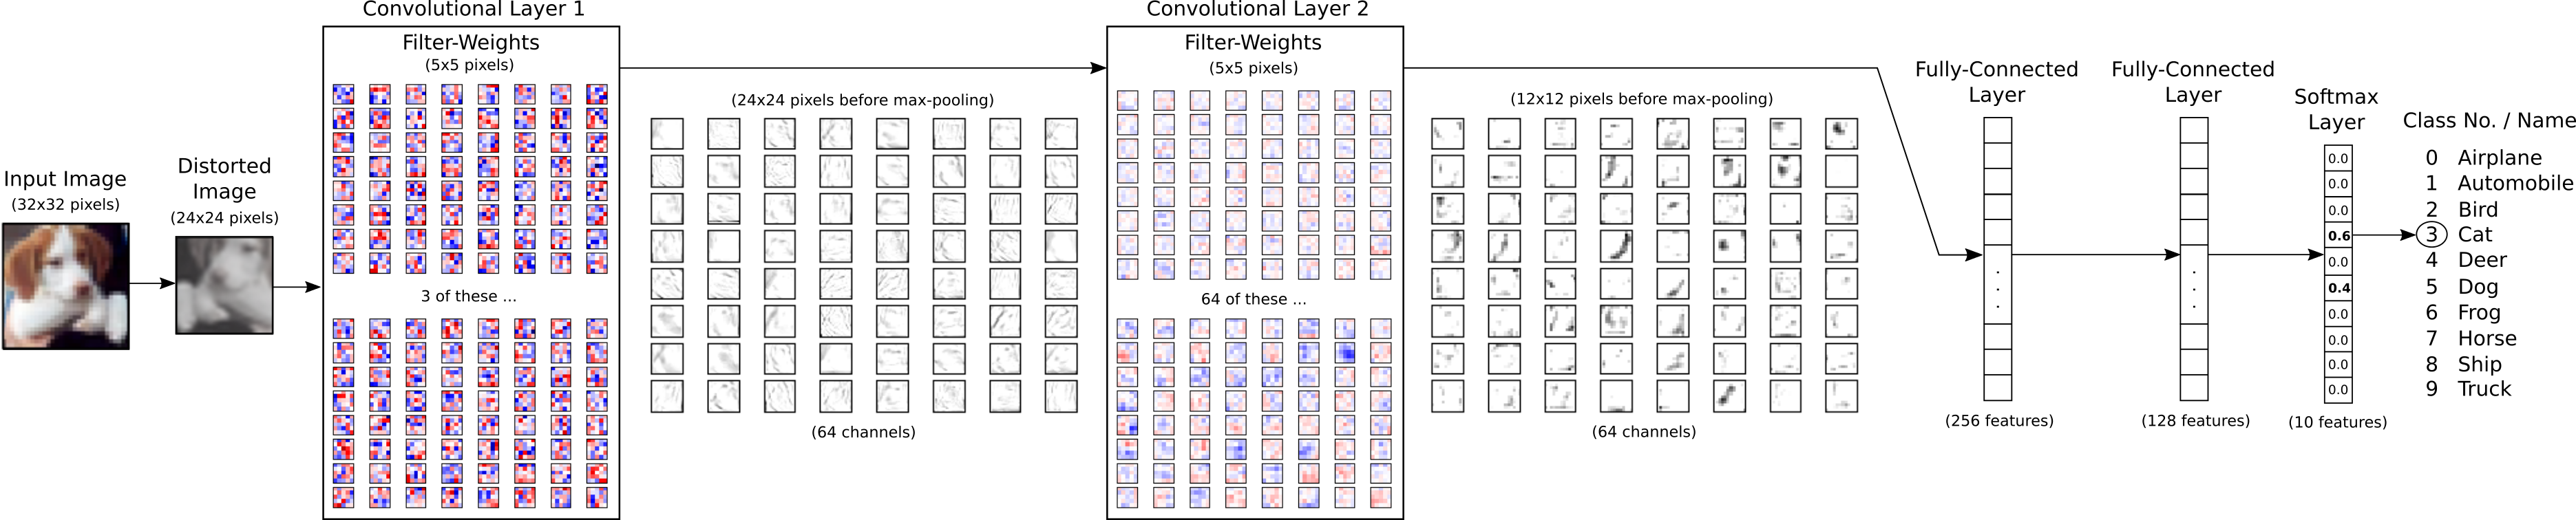

In [1]:
from IPython.display import Image
Image('images/06_network_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

파이썬 3.5.2 (아나콘다)와 텐서플로 1.0.1 버젼으로 함

In [3]:
tf.__version__

'1.0.1'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.4'

## Load Data

In [5]:
import cifar10

컴퓨터에 데이터셋을 저장할 경로

In [6]:
# cifar10.data_path = "data/CIFAR-10/"

CIFAR-10 데이터셋은 약 163 MB이고 주어진 경로에 CIFAR-10 데이터셋이 없으면 자동으로 다운로드될 것이다.

In [7]:
cifar10.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


클래스이름을 불러온다.

In [8]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

학습데이터셋을 불러온다. 이것은 이미지, 정수로된 클래스 숫자, 라벨이라 불리는 One-Hot 인코딩된 클래스 숫자 배열을 반환한다

In [9]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


테스트셋을 불러온다

In [10]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


CIFAR-10 데이터셋은 불러와지고, 60,000 장의 이미지들과 관련된 라벨로 구성된다. 이 데이터셋은 학습데이터셋과 테스트셋의 2개의 상호 배반적인 하위 데이터셋으로 나뉘어진다.

In [11]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


### Data Dimensions

이 데이터 차원은 여러 위치에서 자주 사용된다. cifar10 모듈 안에 이미 정의되어 있으므로, 그것들을 불러와 사용할 것이다.

In [12]:
from cifar10 import img_size, num_channels, num_classes

이미지들은 32 x 32 픽셀이지만, 우리는 24 x 24 픽셀로 자를 것이다

In [13]:
img_size_cropped = 24

### Helper-function for plotting images

3x3 격자에 9개의 이미지를 출력하고, 각 이미지에 대해 예측 클래스와 실제값을 보여주는 함수

In [14]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    
    # 이미지의 길이와 cls_true의 값이 9가 맞는지 확인 아니면 에러
    assert len(images) == len(cls_true) == 9

    # subplots로 3x3 격자 figure를 만듬
    fig, axes = plt.subplots(3, 3)

    # 앙상블과 최고 신경망을 출력하는 것이 필요하다면 수직 간격을 조정해라
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    # 각 격자의 떨어진 정도를 조정함
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    # 각 격자의 순서대로 넣기 위해 enumerate를 사용
    for i, ax in enumerate(axes.flat):
        # 보간법 타입
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # 이미지 표시
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # 실제 클래스의 이름
        cls_true_name = class_names[cls_true[i]]

        # 실제와 예측 클래스를 보여준다
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # 예측된 클래스의 이름
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # x 축 라벨에 실제 클래스를 보여줌
        ax.set_xlabel(xlabel)
        
        # 눈금 지움
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Plot a few images to see if data is correct

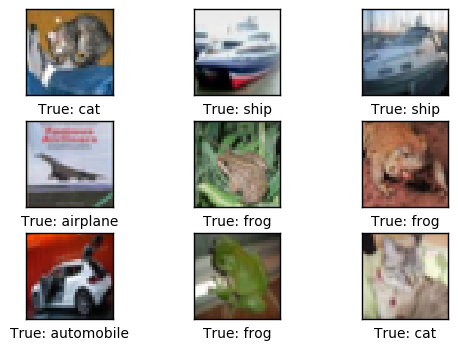

In [16]:
# 테스트셋에서 첫 9개 이미지 가져옴
images = images_test[0:9]

# 이들 이미지의 실제 클래스값 얻음
cls_true = cls_test[0:9]

# 위의 함수를 이용해 나타냄
plot_images(images=images, cls_true=cls_true, smooth=False)

위의 픽셀화된 이미지는 신경망이 입력으로써 받을 것이다. 이 이미지는 픽셀을 부드럽게 한다면 사람눈이 인식하기에 약간 더 쉬워질 것이다

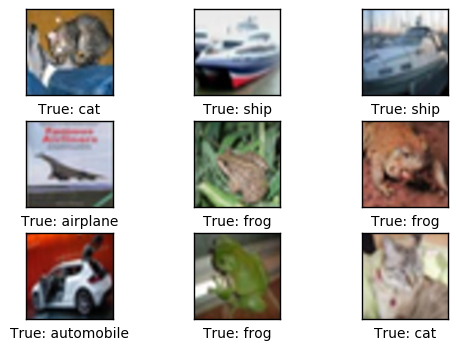

In [17]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## TensorFlow Graph

텐서플로의 목적은 파이썬에서 같은 연산을 실행하는 것보다 효율적으로 실행할 수 있는 계산 그래프(computational graph)를 갖는 것이다. 텐서플로는 넘파이가 매 순간 하나의 수식 연산만 아는 것과는 달리 실행될 때에 모든 계산 그래프를 알고 있어야하기 때문에 더 효율적이다.

텐서플로는 모델이 더 나은 성능을 내기 위해서 그래프의 변수들을 최적화하기 위해 필요한 그라디언트를 자동으로 계산할 수 있다. 이 그래프가 하나의 수식 연산의 결합이기 때문에 체인룰을 이용해 전체 그래프의 그라디언트를 계산할 수 있다.

텐서플로는 또한 멀티코어 CPU 이점도 있다.

텐서플로 그래프는 아래의 파트로 구성된다:
- Placeholder 변수는 그래프의 입력을 바꿀 때 사용
- Model 변수는 최적화될 변수
- 모델은 placeholder 변수와 model 변수들이 주어질 때 출력을 계산하는 수학 함수
- 비용은 변수의 최적화에 사용
- 최적화방법은 모델의 변수를 업데이트 하는 것

게다가, 텐서플로 그래프는 이 튜토리얼에서 다루지는 않지만, 텐서보드를 사용해 보기위한 로그를 남기기 위한 다양한 디버깅 스테이트먼트를 포함할 수 있다. 

### Placeholder variables

Placeholder 변수는 그래프를 실행할 때 바뀔 수도 있는 그래프에 입력값을 보낸다.
아래에서 시연한다.

첫째, 입력 이미지에 대한 placeholder 변수를 정의한다. 텐서 그래프에 입력으로 변할 수 잇는 이미지를 보낸다. 이것이 다차원 벡터 혹은 행렬을 의미하는 텐서다. 데이터 타입은 float32 이고 모양은 [None, img_size_flat] 이다. None 은 정해지지 않았음을 의미한다. 각 이미지는 항상 img_size_flat의 길이를 갖는다.

In [18]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

다음으로 입력 이미지에 해당하는 실제 라벨의 placeholder를 만든다. 이 placeholder 변수의 모양은 [None, num_classes] 이다. None은 미정이고, num_classes 는 여기서는 10이다.

In [19]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

마지막으로, 각 이미지에 해당하는 클래스를 적어둔 라벨을 만든다. 정수

In [20]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Helper-function for creating Pre-Processing

뒤에 도움 함수는 입력 이미지를 전처리 하는 텐서플로 계산 그래프의 부분을 만든다. 이 시점에서는 아무것도 실제로 계산되지 않고, 이 함수는 단지 텐서플로를 위한 계산 그래프에 노드를 더하는 것뿐이다.

전처리는 신경망의 학습과 평가에서 다르다:
* 학습 동안, 입력 이미지는 무작위로 잘리고, 무작위로 수평 반전되고, 색조, 대비, 채도는 무작위로 조저된다. 이것은 입력 이미지의 다양한 변화를 만듦으로써 학습 데이터셋의 크기를 인공적으로 부풀린다. 왜곡된 이미지의 예는 아래에 있다.

* 평가 동안, 입력 이미지는 중앙 주위로 잘리고 다른 것은 조정되지 않는다

In [21]:
def pre_process_image(image, training):
    # 이 함수는 입력으로 하나의 이미지를 받고
    # 학습인지 평가인지 나타내는 진리값을 받는다
    
    if training:
        # 학습 동안, 텐서플로 그래프에 더해진다

        # 입력 이미지를 무작위로 자른다
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # 이미지를 수평적으로 반전시킨다
        image = tf.image.random_flip_left_right(image)
        
        # 색조, 대비 채도를 무작위로 조정한다
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # 이들 함수 몇몇은 오버 플로우를 일으킬 수도 있어서 픽셀의 결과값이 [0,1] 범위를 넘는다
        # 그래서 단순하게 범위의 한계를 짓는다

        # 픽셀별로 [0,1] 사이에 오게 한다
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # 평가 동안, 텐서플로 그래프에 추가된다

        # 이미지 중심 근처에서 입력 이미지를 자르므로 학습동안 무작위로 잘랐던 이미지 크기와 동일하다
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

위의 함수는 아래 함수를 사용해 입력 배치에서 각 이미지에 대해 호출된다

In [22]:
def pre_process(images, training):
    # 입력에 대해 반복적하는 map_fn을 통해
    # 입력으로 하나의 이미지를 갖는 위의 함수를 호출한다
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

왜곡된 이미지를 나타내기 위해, 전처리 그래프를 만들고, 나중에 실행시킨다

In [23]:
distorted_images = pre_process(images=x, training=True)

### Helper-function for creating Main Processing

콘볼루션 신경망의 주요 부분을 만드는 함수. PrettyTensor를 사용한다

In [32]:
def main_network(images, training):
    # 입력 이미지를 Pretty Tensor 객체로 바꾼다
    x_pretty = pt.wrap(images)

    # PrettyTensor는 학습과 평가 부분 사이의 구분을 나타내기위한 특별한 수들을 사용한다
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Pretty Tensor를 사용해 콘볼루션 신경망을 만든다
    # 이전 튜토리얼에서 했던 것과 매우 유사하지만
    # 첫번째 레이어에서 batch_normalization을 사용한다
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

### Helper-function for creating Neural Network

전처리와 주요부분으로 구성된 완전한 신경망을 만드는 함수
신경망은 'network' 라는 변수 범위 안에 담겨있다. 우리가 실제로 텐서플로 안에 두개의 그래프를 만들기 때문이다. 변수 범위를 할당함으로써, 두개의 신경망에 대해 변수를 다시 사용할 수 있으므로, 이 변수들은 학습동안 최적화 되고, 평가를 위해 사용되는 다른 신경망을 위해 재 사용된다 

In [33]:
def create_network(training):
    # 'network'라는 이름 범위 안에 신경망을 싼다
    # 학습 동안 변수들을 만들고, 평가 동안 재사용한다
    with tf.variable_scope('network', reuse=not training):
        # 편의를 위해 입력 placeholder 변수를 다시 이름 짓는다
        images = x

        # 전처리를 위해 텐서플로 그래프를 만든다
        images = pre_process(images=images, training=training)

        # 주요 신경망을 위해 텐서플로 그래프를 만든다
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Create Neural Network for Training Phase

처음은 지금까지 수행한 최적화 반복 횟수를 추적하는 텐서플로 변수를 만든다. 이전 튜토리얼에서 이건 파이썬 변수였지만, 이 튜토리얼에선 체크포인트에서 다른 텐서플로 변수들과 함께 이 변수를 저장하기 원한다

`trainable=False' 는 이 변수는 최적화를 위해 시도하지 않음을 의미한다

In [34]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

학습동안 사용될 신경망을 만든다. `create_network()` 함수는 `y_pred` 와 `loss`를 반환하지만, 우리는 학습동안 `loss` 만 필요하다

In [35]:
_, loss = create_network(training=True)

`loss` 함수를 최소화할 최적화기를 만든다. `global_step` 변수를 최적화기에 보내므로 각 반복후에 하나씩 증가할 것이다.

In [37]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Create Neural Network for Test Phase / Inference

평가를 위한 신경망을 만든다. `create_network()`는 입력 이미지에 대한 예측 클래스 라벨 `y_pred`와 최적화 동안 사용될 `loss` 함수를 반환한다. 평가 동안에는 `y_pred`만 필요하다

In [38]:
y_pred, _ = create_network(training=False)

정수인 예측 클래스 숫자를 계산한다. `y_pred`는 10 요소를 갖는 배열이다. 클래스 숫자는 이 배열에서 가장 큰 요소의 인덱스이다.

In [39]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

각 이미지의 실제 클래스와 예측 클래스가 동일한지를 나타내는 진리값 벡터를 만든다

In [40]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

correct_prediction 이 boolean 값이기 때문에 float32 형태로 가져와 정확도를 계산한다.

In [41]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

신경망의 변수들을 저장하기 위해서, 텐서플로 그래프의 변수들을 저장하고 가져오기 위해 사용되는 Saver 객체를 만든다. 이 시점에서 아무것도 저장되지 않는다.

In [42]:
saver = tf.train.Saver()

### Getting the Weights

아래에서, 우리는 신경망의 가중치를 나타내길 원한다. 신경망이 Pretty Tensor를 사용해 구성될 때, 레이어들의 모든 변수들은 Pretty Tensor에 의해 간접적으로 생성된다. 그래서 우리는 텐서플로로부터 이 변수들을 가져와야만 한다.

우리는 두개의 콘볼루션 레이어에 대해 `layer_conv1` 과 `layer_conv2`의 이름을 사용한다. 이들은 변수 범위를 말한다. Pretty Tensor는 자동적으로 각 레이어에 대해 변수들의 이름을 생성하므로, 우리는 레이어의 범위이름과 변수이름을 사용해 레이어의 가중치를 가져올 수 있다

이 구현은 약간 어색하다 왜냐하면 우리가 다른 목적으로 설계된 텐서플로 함수 `get_variable()` 를 사용하기 때문이다; 가장 쉬운 것은 도움함수를 만드는 것이다

In [43]:
def get_weights_variable(layer_name):
    # 주어진 레이어 이름을 갖는 범위 안에서 'weights' 변수를 가져온다

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

도움함수를 사용해 이 변수들을 가져올 수 있다. 이들은 텐서플로 객체다. 이 변수들의 내용을 얻기 위해, `contents = session.run(weights_conv1)` 과 같이 해야만 한다.

In [44]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### Getting the Layer Outputs

유사하게 우리는 콘볼루션 레이어의 출력을 가져올 필요가 있다. 위에서 가중치를 가져오는 함수와 약간 다르다. 여기서 콘볼루션 레이어에 의채 출력된 마지막 텐서를 가져오자.

In [45]:
def get_layer_output(layer_name):
    # 콘볼루션 레이어의 마지막 연산의 이름
    # 활성화함수로써 Relu를 썼다고 가졍한다
    tensor_name = "network/" + layer_name + "/Relu:0"

    # 이 이름을 갖는 텐서를 가져온다
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

콘볼루션 레이어의 출력을 가져왔으므로 우리는 나중에 그릴 수 있다

In [46]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

## TensorFlow Run

### Create TensorFlow session

텐서플로 그래프가 만들어지면, 우리는 그래프를 실행하기 위해 사용되는 텐서플로 세션을 만들어야만 한다.

In [47]:
session = tf.Session()

### Restore or initialize variables

신경망 학습은 만약 GPU가 없다면 매우 오랜 시간이 걸릴 수 있다. 그러므로 우리는 학습 동안 체크포인트를 저장하므로 다른 시간에 학습을 계속할 수 있고 (e.g 밤 동안), 또한 매번 학습을 하지 않고 성능을 분석 할 수 있다

만약 네가 신경망의 학습을 다시 시작하고 싶다면, 첫번째 체크포인트를 지워야만 한다.

체크 포인트에 대해 사용할 디렉토리다

In [48]:
save_dir = 'checkpoints/'

존재하지 않으면 디렉토리를 만든다.

In [50]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

체크포인트를 위한 기본 파일명, 텐서플로는 여기에 반복 횟수등을 더한다

In [51]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

최근 체크포인트로부터 불러오는 것을 시도하자. 이건 실패하고 에러 낼 수도 있다. 예를 들어 만약 체크포인트가 존재하지 않거나, 텐서플로 그래프를 바꾼 경우

In [52]:
try:
    print("Trying to restore last checkpoint ...")

    # 최근 체크포인트를 찾는다
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # 체크포인트에 데이터를 불러오는 것을 시도한다
    saver.restore(session, save_path=last_chk_path)

    # 체크포인트를 얻는다면 체크포인트가 불러와진다
    print("Restored checkpoint from:", last_chk_path)
except:
    # 몇몇 이유로 실패한다면, 텐서플로 그래프의 모든 변수들을 단순히 초기화한다
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.


### Helper-function to get a random training-batch

학습 데이터셋에 5만 개 이미지가 있다. 모든 이미지를 사용해 그라디언트를 계산하는데에는 너무 오래걸린다. 그래서 매 반복마다 이미지의 표본을 사용하는 확률적 기울기 강하(Stochastic Gradient Descent)를 사용한다.

만약 컴퓨터가 RAM 때문에 너무 느리거나 멈추면, 더 작은 수를 시도해라.

In [53]:
train_batch_size = 64

학습 데이터셋으로부터 무작위 이미지의 배치를 선택하는 함수

In [55]:
def random_batch():
    # 학습 데이터셋 안에 이미지 수
    num_images = len(images_train)

    # 무작위 인덱스 만들기
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # 무작위 인덱스를 이용해 이미지와 라벨을 선택함
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### Helper-function to perform optimization

최적화 반복을 수행함으로써 신경망 레이어의 변수들을 점진적으로 향상 시킨다. 각 반복에서 새로운 데이터 배치가 선택되고 이들 표본을 사용해 최적화기를 실행한다. 진행은 매 100번 반복마다 출력된다. 체크포인트는 매 1000번 반복마다 저장된다.

In [56]:
def optimize(num_iterations):
    # 아래에 사용된 시간을 나타내는 start_time
    start_time = time.time()

    for i in range(num_iterations):
        # 학습 데이터의 표본을 얻는다.
        # x_batch는 이미지의 표본을 가지고 있고,
        # y_true_batch는 이들 이미지에 대한 실제 라벨을 갖고 있다.
        x_batch, y_true_batch = random_batch()

        # 텐서플로 그래프에서 placeholder 변수의 이름을 갖는 사전속에 표본을 넣는다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 학습 자료의 이 표본을 사용해 최적화기를 실행한다.
        # 텐서플로는 feed_dict_train에 있는 변수들을 placeholder 변수에 할당하고 실행한다.
        # global_step 값을 가져온다
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # 매 100번 반복마다 상태 표시
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # 학습 배치에 대한 정확도 계산
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # 상태 출력
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # 매 1000번 반복마다 디스크에 저장
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # 텐서플로 그래프의 모든 변수를 저장한다
            # 파일명에 global_step 을 더함으로써 우리는 마지막 몇 개의 체크포인트를 저장한다
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # 끝난 시간
    end_time = time.time()

    # 시작과 끝 시간 차이
    time_dif = end_time - start_time

    # 시간 사용 출력
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

잘못 분류된 테스트셋의 이미지를 표시하는 함수

In [81]:
def plot_example_errors(cls_pred, correct):
    # 이 함수는 print_test_accuracy() 로부터 불러와진다.
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # correct 는 테스트 셋에 모든 이미지에 대한 실제와 예측의 진리값
    
    # 잘못 분류된 인덱스를 얻는다
    incorrect = (correct == False)
    
    # 올바르게 분류되지 않은 이미지를 얻는다
    images = images_test[incorrect]
    
    # 이들 이미지의 예측 클래스를 얻는다
    cls_pred = cls_pred[incorrect]

    # 이들 이미지의 실제 클래스를 얻는다.
    cls_true = cls_test[incorrect]
    
    # 9개의 이미지를 나타낸다.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [82]:
def plot_confusion_matrix(cls_pred):
    # 이건 아래의 print_test_accuracy()에서 호출된다

    # cls_pred는 테스트셋에 모든 이미지에 대한 예측 클래스 숫자의 배열

    # sklearn 을 사용해 혼동 행렬을 얻는다
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # 혼동 행렬을 텍스트로 출력한다
    for i in range(num_classes):
        # 각 라인에 클래스 이름을 더한다
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Helper-functions for calculating classifications

이 함수는 이미지의 예측 클래스를 계산하고, 각 이미지의 분류가 올바른지 나타내는 진리값을 반환한다

이 계산은 배치에서 수행된다 왜냐하면 RAM을 많이 사용할 수 있기 때문이다. 만약 컴퓨터가 멈춘다면 배치 사이즈를 줄이고 다시 해라

In [83]:
# 데이터를 몇개씩 나눌 것인지
batch_size = 256

def predict_cls(images, labels, cls_true):
    # 이미지의 수
    num_images = len(images)

    # 배치에서 계산되기 위한 예측 클래스의 배열을 할당하고 이 배열 속에 채운다.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # 배치에 대해 예측 클래스를 계산한다.
    # 모든 배치에 대해 반복할 것

    # 배치를 위한 순번 초기화
    i = 0
    
    # i가 테스트셋 숫자보다 작은 경우 계속
    while i < num_images:
        # j 는 배치의 끝 번호
        j = min(i + batch_size, num_images)

        # i부터 j까지의 이미지와 라벨을 feed_dict 으로 만든다
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # 텐서플로를 사용해 예상 클래스를 만든다
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # 다음 배치를 위해 i를 j로 바꾼다
        i = j

    # 예상 클래스와 실제 클래스르 비교한다.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

테스트 셋에 대한 예측 클래스를 계산한다

In [84]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for the classification accuracy

이 함수는 각 이미지가 정확히 분류되었는지 아닌지에 대한 진리값이 주어졌을 때 분류 정확도를 계산한다.
E.g. `cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4`

In [85]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Helper-function for showing the performance

테스트 셋에 대한 분류 정확도를 출력하는 함수

테스트 셋에 모든 이미지에 대한 분류를 계산한다. 결과는 이 함수로부터 직접적으로 위의 함수에 호출되어 재사용된다. 그래서 분류는 각 함수마다 재 계산되지 않는다.

In [86]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # 테스트셋에 모든 이미지에 대해 맞았는지 틀렸는지 나타낸다.
    correct, cls_pred = predict_cls_test()

    # 정확도를 계산한다.
    acc, num_correct = classification_accuracy(correct)
    
    # 이미지의 수
    num_images = len(correct)

    # 정확도 출력
    msg = "테스트셋에 대한 정확도: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # 원한다면 틀린 그림을 표시할 수 있다
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # 원한다면 혼동 행렬을 표시할 수 있다
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Helper-function for plotting convolutional weights

In [87]:
def plot_conv_weights(weights, input_channel=0):
    # 가중치는 4차원 변수에 대한 텐서플로 연산
    # e.g. weights_conv1 or weights_conv2.

    # 텐서플로로부터 가중치 변수들의 값을 가져온다
    # 계산되지 않으므로 feed_dict은 필요하지 않다
    w = session.run(weights)

    # 가중치에 대한 통계량 출력
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # 가중치의 최소값, 최대값을 가져온다
    # 이미지에 대한 색 강도를 조정하기 위해 사용되고,  그래서 그들 각각을 비교가능하다. 
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # 콘볼루션 레이어에서 사용된 필터의 수
    num_filters = w.shape[3]

    # 도표로 그리기 위해 격자로 만든다.
    # 필터의 수의 제곱근을 구하고 올림한다.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # 필터 갯수 만큼 서브플랏을 만든다
    fig, axes = plt.subplots(num_grids, num_grids)

    # 모든 가중치를 그린다
    for i, ax in enumerate(axes.flat):
        # 유효한 필터 가중치만 표시한다
        if i<num_filters:
            # 입력 채널의 i번째 필터에 대한 가중치를 얻는다
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # 눈금을 지운다.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # 하나의 노트북 셀에서 모든 도표를 나타낸다.
    plt.show()

### Helper-function for plotting the output of convolutional layers

In [108]:
def plot_layer_output(layer_output, image):
    # layer_output 은 4차원 텐서로 가정한다
    # e.g. output_conv1 or output_conv2.

    # 하나의 입력 이미지를 갖는 feed_dict을 만든다
    #텐서플로는 이미지의 리스트를 원하므로 하나의 이미지를 갖는 리스트를 만든다
    feed_dict = {x: [image]}
    
    # 입력된 이미지의 레이어 출력을 얻는다
    values = session.run(layer_output, feed_dict=feed_dict)

    # 최소값, 최대값을 가져온다
    # 이미지에 대한 색 강도를 조정하기 위해 사용되고,  그래서 그들 각각을 비교가능하다. 
    values_min = np.min(values)
    values_max = np.max(values)

    # 콘볼루션 레이어에서 사용된 필터의 수
    num_images = values.shape[3]

    # 도표로 그리기 위해 격자로 만든다.
    # 필터의 수의 제곱근을 구하고 올림한다.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # 필터 갯수 만큼 서브플랏을 만든다
    fig, axes = plt.subplots(num_grids, num_grids)

    # 모든 가중치를 그린다
    for i, ax in enumerate(axes.flat):
        # 유효한 필터 가중치만 표시한다
        if i<num_images:
            # 입력 채널의 i번째 필터에 대한 가중치를 얻는다
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # 눈금을 지운다.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # 하나의 노트북 셀에서 모든 도표를 나타낸다.
    plt.show()

## Examples of distorted input images

학습 동안 가능한 이미지의 수를 인공적으로 부풀리기 위해, 신경망은 입력 이미지의 무작위 왜곡을 갖는 전처리를 사용한다. 이건 신경망이 이미지들을 분류하고 인식하는데 더 유연하게 만든다.

왜곡된 입력 이미지들을 출력하기 위한 함수

In [89]:
def plot_distorted_image(image, cls_true):
    # 입력 이미지를 9번 반복한다
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # 텐서플로를 위한 feed_dict을 만든다
    feed_dict = {x: image_duplicates}

    # feed_dict 내의 이미지들을 왜곡하는 텐서플로 그래프의 전처리를 계산한다
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

테스트셋으로부터 이미지와 클래스 숫자를 가져오는 도움함수

In [90]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

테스트 셋으로부터 이미지와 실제 클래스를 가져온다

In [91]:
img, cls = get_test_image(16)

이미지의 9가지 무작위 왜곡을 출력한다. 만약 이 코드를 다시 실행하면 다른 결과를 얻을 것이다.

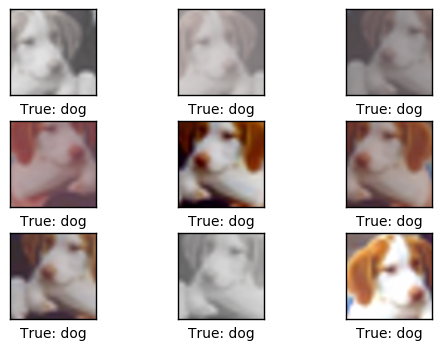

In [92]:
plot_distorted_image(img, cls)

## Perform optimization

내 노트북은 2 GHz의 쿼드코어다. GPU가 있으나 텐서플로를 돌리기에 충분히 빠르지 않고 그래서 CPU를 사용한다. 이 PC에서 CPU를 사용해 10,000 번의 최적화 반복을 하는데 약 1 시간이 걸린다. 이 튜토리얼은 150,000 번 최적화 반복을 수행했고, 그래서 약 15시간이 걸린다. 
밤에 돌리고 낮에도 여러 시간에 돌렸다

왜냐하면 최적화 동안 체크포인트를 저장하기 때문이고, 코드를 재 시작할 때 최근 체크포인트로부터 불러오기 때문에 우리는 멈출 수 있고 나중에 계속할 수 있다

In [117]:
if False:
    optimize(num_iterations=1000)

Global Step:   1100, Training Batch Accuracy:  53.1%
Global Step:   1200, Training Batch Accuracy:  53.1%
Global Step:   1300, Training Batch Accuracy:  42.2%
Global Step:   1400, Training Batch Accuracy:  34.4%
Global Step:   1500, Training Batch Accuracy:  48.4%
Global Step:   1600, Training Batch Accuracy:  45.3%
Global Step:   1700, Training Batch Accuracy:  45.3%
Global Step:   1800, Training Batch Accuracy:  51.6%
Global Step:   1900, Training Batch Accuracy:  56.2%
Global Step:   2000, Training Batch Accuracy:  48.4%
Saved checkpoint.
Global Step:   2100, Training Batch Accuracy:  48.4%
Global Step:   2200, Training Batch Accuracy:  57.8%
Global Step:   2300, Training Batch Accuracy:  46.9%
Global Step:   2400, Training Batch Accuracy:  46.9%
Global Step:   2500, Training Batch Accuracy:  50.0%
Global Step:   2600, Training Batch Accuracy:  60.9%
Global Step:   2700, Training Batch Accuracy:  59.4%
Global Step:   2800, Training Batch Accuracy:  50.0%
Global Step:   2900, Trainin

## Results

After 150,000 optimization iterations, the classification accuracy is about 79-80% on the test-set. Examples of mis-classifications are plotted below. Some of these are difficult to recognize even for humans and others are reasonable mistakes e.g. between a large car and a truck, or between a cat and a dog, while other mistakes seem a bit strange.

테스트셋에 대한 정확도: 80.6% (8063 / 10000)
Example errors:


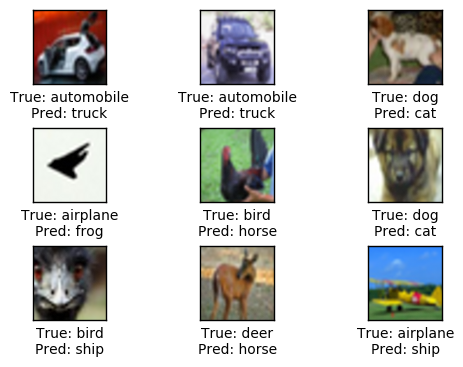

Confusion Matrix:
[806  19  33  12  14   8   8  11  51  38] (0) airplane
[ 10 889   4   7   1   1   4   1  15  68] (1) automobile
[ 37   4 681  48  73  33  59  40  14  11] (2) bird
[ 13  11  30 619  56 124  58  53  16  20] (3) cat
[ 11   3  25  27 803  19  29  66   8   9] (4) deer
[  5   7  29 139  28 685  27  63   3  14] (5) dog
[  6   6  15  33  24  13 878   7   3  15] (6) frog
[  6   0  10  21  36  22   5 893   0   7] (7) horse
[ 25  13   6   3   5   4   2   4 904  34] (8) ship
[ 15  37   0   6   3   0   3  12  19 905] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [118]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Convolutional Weights

첫번째 콘볼루션에 대한 가중치를 보여준다. 3개의 입력 채널이 있으므로 이들 집합들은 `input_channel`에 따라 변하는 3개가 있다

양의 가중치는 빨강이고 음의 가중치는 파랑이다.

Min:  -0.61209, Max:   0.73872
Mean: -0.00094, Stdev: 0.17041


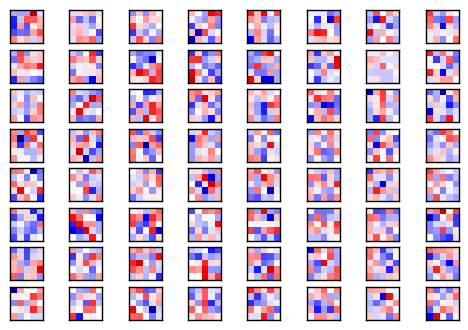

In [119]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

두번째 콘볼루션 레이어에 대한 가중치 표시. 이들은 첫번째 콘볼루션에 가중치들보다 0에 가깝다. 낮은 표준편차를 보라

Min:  -0.48947, Max:   0.27841
Mean: -0.00412, Stdev: 0.05436


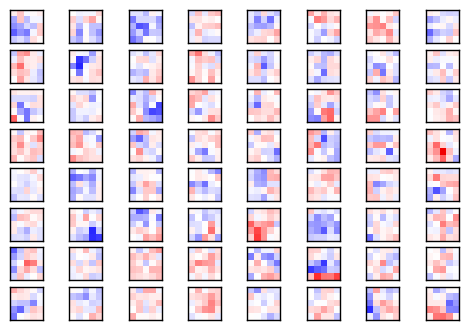

In [120]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers

이미지 그리기 도움함수

In [96]:
def plot_image(image):
    fig, axes = plt.subplots(1, 2)

    # 서브 플랏의 메모리 참조점
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # 서브 플랏에 원래 이미지와 부드럽게한 이미지를 표시한다
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # 라벨을 표시한다
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    plt.show()

테스트셋의 이미지를 표시한다. raw 픽셀화된 이미지는 신경망의 입력으로 사용된다

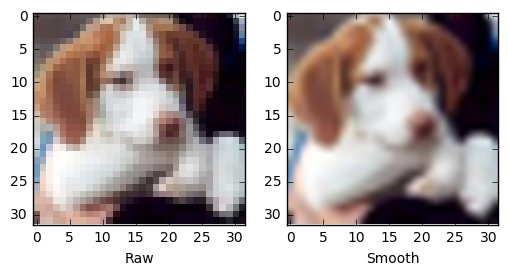

In [97]:
img, cls = get_test_image(16)
plot_image(img)

신경망의 입력으로써 raw 이미지가 사용되고 첫번째 콘볼루션 레이어의 출력을 표시한다

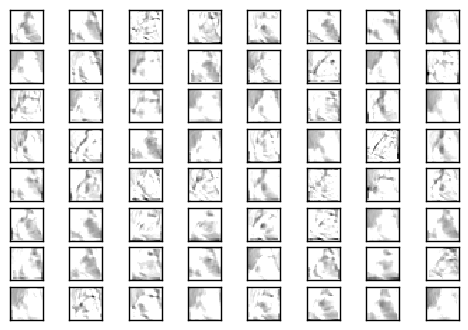

In [109]:
plot_layer_output(output_conv1, image=img)

신경망의 같은 이미지를 입력으로 사용하고, 두번째 콘볼루션 레이어의 출력을 그린다

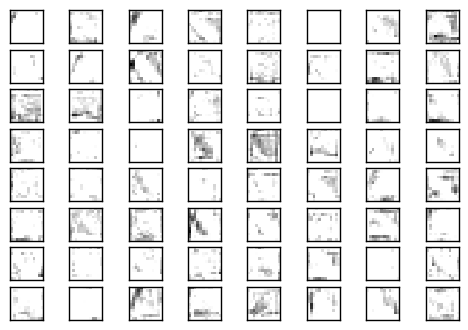

In [110]:
plot_layer_output(output_conv2, image=img)

### Predicted class-labels

이미지에 대해 예측 라벨과 클래스 숫자를 얻는다

In [111]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img]})

예측 라벨을 출력한다

In [113]:
# 넘파이의 반올림 옵션을 설정
np.set_printoptions(precision=3, suppress=True)

# 예측 라벨 출력
print(label_pred[0])

[ 0.001  0.002  0.027  0.298  0.006  0.565  0.023  0.074  0.     0.004]


예측 클래스 라벨은 10의 길이 배열, 각 요소는 신경망이 이미지가 각 클래스라고 얼마나 신뢰하는지를 나타낸다.

여기서 인덱스 3은 0.493의 값, 인덱스 5는 0.490. 이것은 신경망이 이미지를 클래스 3이나 클래스 5 각각 고양이나 개로 믿는다는 것을 의미한다.

In [114]:
class_names[3]

'cat'

In [115]:
class_names[5]

'dog'

## Close TensorFlow Session

텐서플로 사용을 마쳤고, 리소스를 풀기 위해 세션을 닫는다.

In [116]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

CIFAR-10 데이터셋에 이미지를 분류하기 위해 콘볼루션 신경망을 만드는 방법을 보인다. 분류 정확도는 테스트셋에 약 79-80% 정도였다.

콘볼루션 레이어의 출력을 그렸지만 어떻게 신경망이 인식하는지 알기 어렵다.
더 나은 시각화 기법이 필요하다

## Exercises

* 10,000번 최적화 반복하고 정확도를 보라. 모든 변수들을 저장하는 체크포인트를 만들 것이다
* 계속해서 100,000 번 최적화 수행하고 정확도가 얼마나 향상되는지 보라. 그런 다음 다시 100,000 번 반복하라. 정확도 향상되고 추가적인 계산 시간이 필요하다고 생각하는가?
* 전처리에서 이미지 왜곡을 바꿔라
* 신경망의 구조를 바꿔라. 신경망을 작게 혹은 크게 바꿀 수 있다. 이것은 학습 시간과 분류 정확도에 어덯게 영향을 주는가? 신경망의 구조를 바꿀 때 체크 포인트를 불러올 수 없다
* 두번째 콘볼루션 레이어에 batch normalization을 사용해라. 또한 두 레이어에서 모두 제외해라
* CIFAR-10 에 대한 [better neural networks](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)를 조사하고 그들을 구현해보라
* 프로그램이 어떻게 작동되는지 친구에게 설명하라

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.